In [98]:
import pandas as pd
import os
import re
import glob
import tiktoken
import openai
from openai import OpenAI
from scipy.spatial.distance import cosine
import os
client = OpenAI()



In [ ]:
# API Key 입력. 만일 환경변수에 없으면, 프롬프트로 입력받음.
from dotenv import load_dotenv
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    openai_api_key = input("OpenAI API Key 입력: ")
    os.environ["OPENAI_API_KEY"] = openai_api_key
openai.api_key = os.environ["OPENAI_API_KEY"]

In [70]:
def get_md_files(directory):
    md_files = glob.glob(os.path.join(directory, "**/*.md"), recursive=True)
    return md_files

def process_file_content(file_path):
    # Read and process the file content
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Replace new lines, URLs, and tags
        content = content.replace('\n', ' ').replace('\r', ' ')
        content = re.sub(r'http\S+', '', content)  # Remove URLs
        content = re.sub(r'\{\/\*.*?\*\/\}', '', content)  # Remove {/*text*/}
        content = content.replace('---', '')
        return content

In [71]:
directory = '../../raw'
md_files = get_md_files(directory)
data = []
for file_path in md_files:
    title = os.path.basename(file_path).replace('.md', '')
    content = process_file_content(file_path)
    data.append({'title': title, 'content': content})
df = pd.DataFrame(data, columns=['title', 'content'])


<AxesSubplot: >

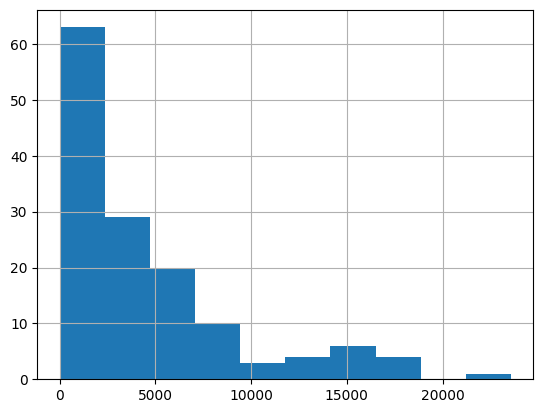

In [72]:
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df['content'].apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [74]:
max_tokens = 2000
def split_into_many(text, max_tokens = max_tokens):

    # 일단 문장으로 쪼개기
    sentences = text.split('. ')

    # 문장마다 몇 토큰 들어가는지 세어 주기.
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []


    for sentence, token in zip(sentences, n_tokens):

        # 문장의 토큰 수와 현재까지의 토큰 수의 합이 최대 토큰 수를 초과하면, 해당 청크를 청크 목록에 추가하고 청크 및 현재까지의 토큰 수를 초기화한다.
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0


        if token > max_tokens:
            continue

        chunk.append(sentence)
        tokens_so_far += token + 1

    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks

In [75]:
shortened = []
# 데이터 프레임 순회하기
for row in df.iterrows():

    # If the content is None, go to the next row
    if row[1]['content'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the content into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['content'])
    
    # Otherwise, add the content to the list of shortened texts
    else:
        shortened.append( row[1]['content'] )

In [76]:
def split_large_text(large_text, max_tokens=2000):
    enc = tiktoken.get_encoding("cl100k_base")
    tokenized_text = enc.encode(large_text)

    chunks = []
    current_chunk = []
    current_length = 0

    for token in tokenized_text:
        current_chunk.append(token)
        current_length += 1

        if current_length >= max_tokens:
            chunks.append(enc.decode(current_chunk).rstrip(' .,;'))
            current_chunk = []
            current_length = 0

    if current_chunk:
        chunks.append(enc.decode(current_chunk).rstrip(' .,;'))

    return chunks

df['splitted_content'] = df['content'].apply(split_large_text)
df = df.explode("splitted_content")
df['spllitted_n_tokens'] = df['splitted_content'].apply(lambda x: len(tokenizer.encode(x)))
df = df.reset_index( drop=True)

In [79]:
df = df[['title','splitted_content', 'spllitted_n_tokens']].rename(columns={'splitted_content':'content', 'spllitted_n_tokens':'n_tokens'})

In [93]:
def combine_info(row):
    title = " ".join(row['title'].split("-"))

    
    combined = [f"title: {title}", f"content: \n{content}"]
    combined = "\n\n###\n\n".join(combined)
    
    return combined

df["combined"] = df.apply(combine_info, axis=1)

,title,content,n_tokens,combined
0,index,id: home title: React permalink: index.html,10,title: index\n\n###\n\ncontent: \n title: crea...
1,updating-objects-in-state,title: Updating Objects in State <Intro> S...,2000,title: updating objects in state\n\n###\n\ncon...
2,updating-objects-in-state,hepworth@sculpture.com' }); function hand...,2000,title: updating objects in state\n\n###\n\ncon...
3,updating-objects-in-state,To try Immer: 1. Run `npm install use-immer...,2000,title: updating objects in state\n\n###\n\ncon...
4,updating-objects-in-state,copy the existing `...player` fields into the...,2000,title: updating objects in state\n\n###\n\ncon...
...,...,...,...,...
379,useDebugValue,title: useDebugValue <Intro> `useDebugValu...,891,title: useDebugValue\n\n###\n\ncontent: \n tit...
380,memo,title: memo <Intro> `memo` lets you skip r...,2000,title: memo\n\n###\n\ncontent: \n title: creat...
381,memo,; margin-bottom: 16px; } ``` </Sandpack> I...,1432,title: memo\n\n###\n\ncontent: \n title: creat...
382,createFactory,title: createFactory <Deprecated> This API...,1236,title: createFactory\n\n###\n\ncontent: \n tit...


In [99]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [100]:
# df["embedding"] = df.combined.apply(get_embedding)
# df.to_pickle("../../processed/react-processed.pkl")

In [106]:
df = pd.read_pickle("../../processed/react-processed.pkl")

,title,content,n_tokens,combined,embedding
0,index,id: home title: React permalink: index.html,10,title: index\n\n###\n\ncontent: \n title: crea...,"[0.017282074317336082, 0.04509170353412628, -0..."
1,updating-objects-in-state,title: Updating Objects in State <Intro> S...,2000,title: updating objects in state\n\n###\n\ncon...,"[0.016962481662631035, 0.04796011373400688, -0..."
2,updating-objects-in-state,hepworth@sculpture.com' }); function hand...,2000,title: updating objects in state\n\n###\n\ncon...,"[0.016962481662631035, 0.04796011373400688, -0..."
3,updating-objects-in-state,To try Immer: 1. Run `npm install use-immer...,2000,title: updating objects in state\n\n###\n\ncon...,"[0.016962481662631035, 0.04796011373400688, -0..."
4,updating-objects-in-state,copy the existing `...player` fields into the...,2000,title: updating objects in state\n\n###\n\ncon...,"[0.016962481662631035, 0.04796011373400688, -0..."
...,...,...,...,...,...
379,useDebugValue,title: useDebugValue <Intro> `useDebugValu...,891,title: useDebugValue\n\n###\n\ncontent: \n tit...,"[0.01927955262362957, 0.047798339277505875, -0..."
380,memo,title: memo <Intro> `memo` lets you skip r...,2000,title: memo\n\n###\n\ncontent: \n title: creat...,"[0.015324844978749752, 0.04357011988759041, -0..."
381,memo,; margin-bottom: 16px; } ``` </Sandpack> I...,1432,title: memo\n\n###\n\ncontent: \n title: creat...,"[0.015324844978749752, 0.04357011988759041, -0..."
382,createFactory,title: createFactory <Deprecated> This API...,1236,title: createFactory\n\n###\n\ncontent: \n tit...,"[0.015643924474716187, 0.04472710192203522, -0..."


In [104]:
df = pd.read_pickle("../../processed/react-processed.pkl")
def create_context(
    question, df, max_len=3000
):
    q_embeddings = client.embeddings.create(input=question, model='text-embedding-ada-002').data[0].embedding
    df["distances"] = df["embedding"].apply(lambda x: cosine(q_embeddings, x))
    returns = []
    cur_len = 0
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        cur_len += row['n_tokens'] + 4
        if cur_len > max_len:
            break
        returns.append(row["combined"])
    return "\n\n===\n\n".join(returns)


def answer_question(
    df,
    model="gpt-3.5-turbo",
    question="What is difference between useEffect and useLayoutEffect in React?",
    max_len=3000,
    debug=False,
):
    context = create_context(
        question,
        df,
        max_len=max_len,
    )
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\n"},
                {"role": "user", "content": f"context: {context}\n\n---\n\n Question: {question}, 한국어로 대답해줘."}
            ],
            temperature=0,
        )
        return response.choices[0].message.content
    except Exception as e:
        print("Error occurred:", e)
        return ""

In [105]:
answer_question(df, question="What is difference between useEffect and useLayoutEffect in React?")

'useEffect와 useLayoutEffect의 차이점은 다음과 같습니다.\n\n- useEffect는 비동기적으로 실행되며, 컴포넌트가 렌더링된 후에 실행됩니다. 이는 렌더링에 영향을 주지 않고, 렌더링이 완료된 후에 부수 효과를 처리하는 데 사용됩니다.\n- useLayoutEffect는 동기적으로 실행되며, 컴포넌트가 렌더링된 후에 바로 실행됩니다. 이는 렌더링 전에 DOM을 조작하거나 측정해야 하는 경우에 사용됩니다. useLayoutEffect는 useEffect와 달리 브라우저가 화면을 업데이트하기 전에 실행되므로, 사용자에게 더 나은 경험을 제공할 수 있습니다.\n\n따라서, useEffect는 비동기적인 작업에 사용되고, useLayoutEffect는 동기적인 작업에 사용됩니다.'